<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=500></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h1 style="text-align: center;"><b>Object detection</b></h1>
<h1 style="text-align: center;"><b>Индивидуальный проект Максимовой Александра Юрьевны <br />
    <i>Stepic ID: 540874658</i></b></h1>

### Руководитель проекта: 
* Юрий Яровиков (AIRI, МФТИ) | tg:@yu_rovikov

# Исследовательский трек





### 1. Выбор фреймворка/библиотеки для использования детектора (1 балл)

- `torchvision.models.detection`

Будем решать задачу детекции игральной карты. Изображения к задаче лежать в проекте на github TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10
[Детекция игровых карт](https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10): 

Для детекции игральных карт обучим нейросеть fasterrcnn_resnet50_fpn из библиотеки torchvision.models.detection
В качестве feature-extractor данная модель использует ResNet-50-FPN
Загрузим сеть с предобученными весами на данных базы COCO-val2017 с 88 категориями.   
Необходимо заменить FastRCNNPredictor, чтобы заменить выходной слой на линейный с 6 классами игральных карт "деявтяка", "десятка", "валет", "дама", "король", "туз".
model.roi_heads.box_predictor FastRCNNPredictor(in_features, num_classes),
где  in_features  зависит от используемой модели, а num_classes=7, так как 0 - соответсвует категории "фон". 


In [4]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch
torch.manual_seed(17);


### 2. Запуск детектора на случайных изображениях (1 балл)

В этом пункте вам необходимо применить модель детектирования в выбранном выше репозитории (по сути проверить, что инференс в модели работает). Таким образом, вы убедитесь, что модель работает, и сможет переходить к обучению.

> Результатом пункта явлется набор изображений, на которых модель успешно отработала и результат детекции виден и понятен.



In [25]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision.ops import nms
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from pprint import pprint
import pandas as pd
from torchvision.transforms import PILToTensor, Compose, ConvertImageDtype, RandomHorizontalFlip, Resize
import numpy as np
from PIL import Image
from torchvision.transforms import functional as F

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))


class ProblemClasses():
    num_classes=7
    class_num = {"nine": 1, "ten": 2, "jack": 3, "queen": 4, "king": 5, "ace": 6}
    class_name = {1: "nine", 2: "ten", 3: "jack", 4: "queen", 5: "king", 6: "ace"}


In [14]:
class CardDatsSet(DataLoader):
    def __init__(self, root, mode="train", augmentation=False, resize=False):
        super().__init__(self)
        self.mode = mode
        self.root = os.path.join(root, mode)
        self.imgs = list(sorted(os.listdir(self.root)))
        # filename,width,height,class,xmin,ymin,xmax,ymax
        self.df = pd.read_csv(os.path.join(root, mode + "_labels.csv"))
        # self.df["boxes"] = self.df[["xmin", "ymin", "xmax", "ymax"]].apply(list, axis=1)
        self.resize = resize
        self.transform = self.make_transform()
        self.augmentation = augmentation


    def make_transform(self):
        transforms = []
        if self.resize:
            transforms.append(Resize((250, 150)))
        transforms.append(PILToTensor())

        transforms.append(ConvertImageDtype(torch.float))
        return Compose(transforms)

    def __getitem__(self, item):

        flip_augmentation = False if self.augmentation and self.mode == "test" or np.random.random_sample(
            1) < 0.5 else True
        flip_augmentation2 = False if self.augmentation and self.mode == "test" or np.random.random_sample(
            1) < 0.5 else True
        img_path = os.path.join(self.root, self.imgs[item])
        img = Image.open(img_path)
        if flip_augmentation:
            img = F.vflip(img)
        if flip_augmentation2:
            img = F.hflip(img)

        d = self.df[self.df.filename == self.imgs[item]]
        boxes = []
        labels = []
        for n in d.index:
            if flip_augmentation and not (flip_augmentation2):
                # Vertical flip
                box = [d.loc[n].xmin, img.height - d.loc[n].ymax, d.loc[n].xmax, img.height - d.loc[n].ymin]
            elif not (flip_augmentation) and flip_augmentation2:
                # Horisontal flip
                box = [img.width - d.loc[n].xmax, d.loc[n].ymin, img.width - d.loc[n].xmin, d.loc[n].ymax]
            elif flip_augmentation and flip_augmentation2:
                # both vertical and horizontal
                box = [img.width - d.loc[n].xmax, img.height - d.loc[n].ymax, img.width - d.loc[n].xmin,
                       img.height - d.loc[n].ymin]
            else:
                box = [d.loc[n].xmin, d.loc[n].ymin, d.loc[n].xmax, d.loc[n].ymax]
            boxes.append(box)
            labels.append(ProblemClasses.class_num[d.loc[n]["class"]])

        target = {}
        target["boxes"] = torch.Tensor(boxes).to(torch.float)
        target["labels"] = torch.Tensor(labels).to(torch.int64)

        return self.transform(img), target, (flip_augmentation, flip_augmentation2), d.filename

    def __len__(self):
        return len(self.imgs)



In [15]:
def create_model(num_classes, pretrained=False):
    if pretrained:
        pretrained_znach = "DEFAULT"
    else:
        pretrained_znach = None
    model = fasterrcnn_resnet50_fpn(weights=pretrained_znach)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


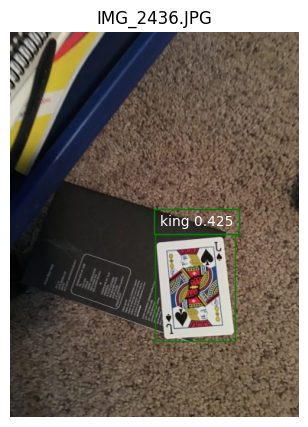

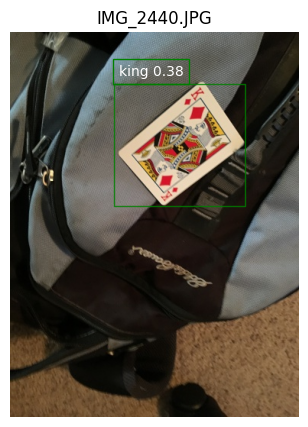

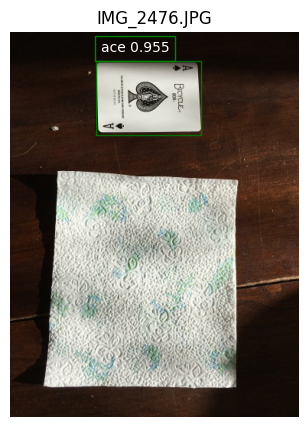

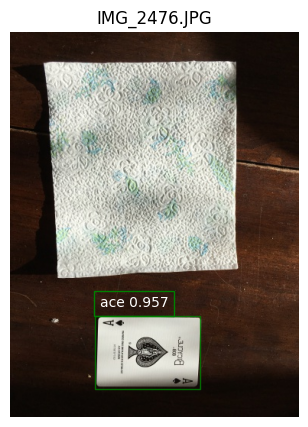

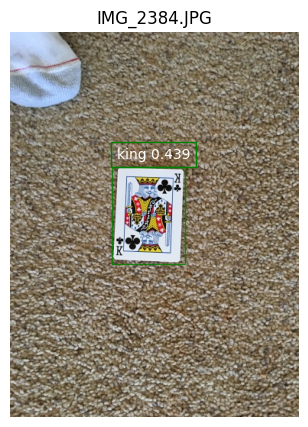

In [30]:

model_name = "fastrrcnn_Adam_lr0.0005_epochs10"
num_classes = ProblemClasses.num_classes
num_workers = 0
batch_size = 1
model = create_model(num_classes, pretrained=False)
model.load_state_dict(torch.load(model_name + ".net"))
model.eval()

ds = CardDatsSet(os.path.join(os.getcwd(), "images"), mode="test")
test_dataloader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
# im, tr, _, _ = next(iter(test_dataloader))
find_nums = np.random.randint(0,66, 5)
for find_num in find_nums:
    model.eval()

    for i, d in enumerate(test_dataloader):
        if i == find_num:
            im = d[0]
            tr = d[1]
            flip_flag = d[2]
            file_name = d[3][0].values[0]
            break

    predict = model(im)
    # metric = MeanAveragePrecision()
    # metric.update(predict, tr)
    # pprint(metric.compute())
    #
    iou_threshold = 0.1
    threshold = 0.35
    
    ind = nms(predict[0]["boxes"], predict[0]["scores"], iou_threshold).detach().cpu().numpy()
    

    boxes = []
    labels = []
    labels_xy = []
    for i, box in enumerate(predict[0]["boxes"][ind]):
        if predict[0]["scores"][i] > threshold:
            boxes.append(Rectangle((box[0].detach().cpu().numpy(), box[1].detach().cpu().numpy()),
                                   (box[2] - box[0]).detach().cpu().numpy(), (box[3] - box[1]).detach().cpu().numpy()))
            labels.append(ProblemClasses.class_name[int(predict[0]["labels"][ind][i].detach().numpy())] + " "
                          + str(round(predict[0]["scores"][i].item(), 3)))
            labels_xy.append([box[0].detach().cpu().numpy(), box[1].detach().cpu().numpy()])
    pc = PatchCollection(boxes, facecolors="none", edgecolors="g", alpha=0.8)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(im[0].permute(1, 2, 0))

    ax.set_title(str(file_name))
    # ax.set_title(str(file_name) + ";" + str(flip_flag) + " flip")
    ax.add_collection(pc)
    for i in range(len(labels)):
        xy = labels_xy[i]
        l = labels[i]
        ax.text(xy[0] + 6, xy[1] - 11, l, bbox={"edgecolor": "g", "facecolor": "none"}, color="w")
        ax.set_axis_off()

    model.train()
    loss_dict = model(im, tr)
    loss = sum(loss for loss in loss_dict.values())
   
    plt.show()
    #fig.savefig(os.path.join("fasterRCNN_result_images_view", str(find_num) + "_" + str(model_name) + ".png"))


### 3. Выбор датасета (0 баллов)


 [Детекция игровых карт](https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10): лежат в папке images вместе с разметкой;


### 4. Предобработка данных (2 балла)
class CardDatsSet(DataLoader) - Приведен раньше по коду

### 5. Обучение моделей-детекторов (3 балла)

Необходимо написать цикл обучения на PyTorch самостоятельно -- это основной критерий в этом пункте. Необходимо обучить обе выбранные модели. 

In [31]:

class adjust:
    MAC = False
    FIRST_STEP = True
    model_name = "fastrrcnn_Adam_lr0.0005_epochs10"
    batch_size = 2
    max_epochs = 2
    num_workers = 4

    optimizer_dict = {"type": "Adam", "lr": 1e-3, "weight_decay": 0.0005}
    # optimizer_dict = {"type": "SGD", "lr": 1e-3, "weight_decay": 0.0005, "momentum": 0.9}
    sheduler = {"step_size": 7, "gamma": 0.3}


In [ ]:
import os
import pickle
import pandas as pd
import time
import torch


from data import CardDatsSet
from model_fasterRCNN import create_model
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from utils import collate_fn, ProblemClasses

if adjust.MAC:
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device is", DEVICE)

FIRST_STEP = adjust.FIRST_STEP
model_name = adjust.model_name
batch_size = adjust.batch_size
max_epochs = adjust.max_epochs
num_workers = adjust.num_workers
sheduler_step_size = adjust.sheduler["step_size"]
sheduler_gamma = adjust.sheduler["gamma"]

dataset_train = CardDatsSet(os.path.join(os.getcwd(), "images"))
dataset_test = CardDatsSet(os.path.join(os.getcwd(), "images"), mode="test")
N_test = len(dataset_test)
train_data = DataLoader(dataset_train,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=num_workers,
                        collate_fn=collate_fn)

test_data = DataLoader(dataset_test,
                       batch_size=batch_size,
                       shuffle=False,
                       num_workers=num_workers,
                       collate_fn=collate_fn)

val_data = DataLoader(dataset_test,
                       batch_size=N_test,
                       shuffle=False,
                       num_workers=num_workers,
                       collate_fn=collate_fn)


def train(model, start_epoch, max_epochs, optim, sheduler):
    time_start = time_next = time.time()
    metric = MeanAveragePrecision()

    model.to(DEVICE)
    losses_train = []
    losses_test = []
    scores_maP = []
    scores_maR = []
    i = 0
    for epoch in range(max_epochs):


        loss_train = 0
        loss_test = 0

        model.train()
        for imgs, targets, _, _ in train_data:
            optim.zero_grad()
            imgs = list(img.to(DEVICE) for img in imgs)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            loss_dict = model(imgs, targets)
            loss = sum(loss for loss in loss_dict.values())
            loss_train += loss.item()
            loss.backward()
            optim.step()

        for imgs, targets, _, _ in test_data:
            imgs = list(img.to(DEVICE) for img in imgs)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            with torch.no_grad():
                loss_dict = model(imgs, targets)
                print("loss_dict", loss_dict)
            loss = sum(loss for loss in loss_dict.values())
            loss_test += loss.item()

        # img_val, targets_val = next(iter(val_data))
        # predict = model(img_val)
        # metric.update(predict, targets_val)
        # scores = metric.compute()
        # scores_maP.append(scores["map"].detach().numpy())
        # scores_maP.append(scores["mar_1"].detach().numpy())


        sheduler.step()
        loss_train = loss_train / len(train_data.dataset)
        loss_test = loss_test / len(test_data.dataset)
        losses_train.append(loss_train)
        losses_test.append(loss_test)
        print("Epoch {}/{}. Loss {}".format(start_epoch + epoch, start_epoch + max_epochs, loss_train))

        print(time.time() - time_next, " c ; current loss on ", i, " : ", loss_train)
        time_next = time.time()
        i += 1
    analysis_data = {"losses_train": losses_train, "losses_test": losses_test,
                    # "scores_map":scores_maP, "scores_mar":scores_maR
                     }
    print(fr"Посчитано за {time.time() - time_start} c")
    return analysis_data


model = create_model(ProblemClasses.num_classes, pretrained=FIRST_STEP)
params = [p for p in model.parameters() if p.requires_grad]
if adjust.optimizer_dict["type"] == "Adam":
    optim = torch.optim.Adam(model.parameters(), lr=adjust.optimizer_dict["lr"],
                             weight_decay=adjust.optimizer_dict["weight_decay"])
elif adjust.optimizer_dict["type"] == "SGD":
    optim = torch.optim.SGD(params, lr=adjust.optimizer_dict["lr"],
                            momentum=adjust.optimizer_dict["momentum"],
                            weight_decay=adjust.optimizer_dict["weight_decay"])
else:
    print("Неизвестныей тип оптимизатора. ")
    exit()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optim,
                                               step_size=sheduler_step_size,
                                               gamma=sheduler_gamma)

if FIRST_STEP:
    f = open("epoch_" + model_name + ".num", "wb")
    epoch_num = 0
    pickle.dump(epoch_num, f)
    if not os.path.exists(model_name + "_epochs"):
        os.mkdir(model_name + "_epochs")
    f.close()
else:
    f = open("epoch_" + model_name + ".num", "rb")
    epoch_num = pickle.load(f)
    model.load_state_dict(torch.load(model_name + ".net"))
    f.close()

analysis_data = train(model, epoch_num, max_epochs, optim, lr_scheduler)
df = pd.DataFrame(analysis_data)

# ----------------Завершение цикла обучения
f = open("epoch_" + model_name + ".num", "wb")
step = epoch_num + max_epochs
pickle.dump(step, f)
f.close()
model = model.to("cpu")
torch.save(model.state_dict(), model_name + ".net")

if FIRST_STEP:
    df.to_csv(model_name + ".csv")
else:
    df.to_csv(model_name + ".csv", mode="a", header=False)



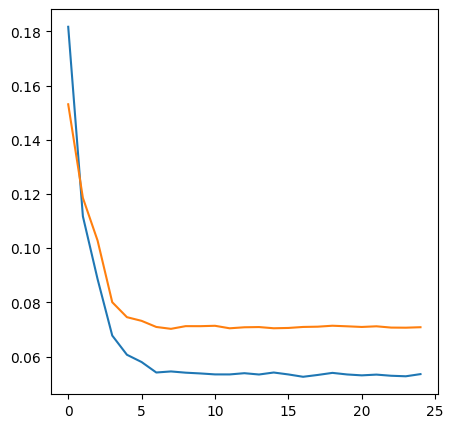

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle


model_name = adjust.model_name


line_style = ["solid", "dotted", "dashed", "dashdot"]


def plot_losses_for_one_nettype_compare(net_name, losses_list):
    fig, ax = plt.subplots(3, 2, figsize=(14, 10), constrained_layout=True)
    fig.suptitle("Анализ сети " + net_name)
    ax[0][0].set_title("losses по выборке train")
    ax[0][1].set_title(" IoU score по выборке train")
    ax[1][0].set_title("losses по выборке test")
    ax[1][1].set_title(" IoU score по выборке test")
    ax[2][0].set_title("losses по выборке val")
    ax[2][1].set_title(" IoU score по выборке val")

    for i in range(len(losses_list)):
        df = pd.read_csv(net_name + "_" + losses_list[i] + ".csv")

        ax[0][0].plot(df["loss_train"], label=str(losses_list[i]), c="#12DDDD", linestyle=line_style[i])
        ax[1][0].plot(df["loss_test"], label=losses_list[i], c="#12DD12", linestyle=line_style[i])
        ax[2][0].plot(df["loss_val"], label=losses_list[i], c="#991122", linestyle=line_style[i])

        ax[0][1].plot(df["score_train"], label=str(losses_list[i]) + str(" {:.3f}".format(df["score_train"].max())),
                      c="#12DDDD", linestyle=line_style[i])
        ax[1][1].plot(df["score_test"], label=str(losses_list[i]) + str(" {:.3f}".format(df["score_test"].max())),
                      c="#12DD12", linestyle=line_style[i])
        ax[2][1].plot(df["score_val"], label=str(losses_list[i]) + str(" {:.3f}".format(df["score_val"].max())),
                      c="#991122", linestyle=line_style[i])

    [ax[i][j].legend() for i in range(3) for j in range(2)]
    [ax[i][1].set_ylim(0, 1) for i in range(3)]

    plt.show()


def plot_compare_losses_for_different_models(models_list):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    for i, model_name in enumerate(models_list):
        df = pd.read_csv(model_name+".csv")
        ax[0].plot(df["losses_train"], label=model_name, c="#12DDDD", linestyle=line_style[i])
        if "losses_test" in df.columns:
            ax[1].plot(df["losses_test"], label=model_name, c="#12DD12", linestyle=line_style[i])
    ax[0].legend()
    ax[1].legend()
    plt.show()


def plot_losses_for_model(model_name):
    df = pd.read_csv(model_name + ".csv")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(df["losses_train"])
    ax.plot(df["losses_test"])
    plt.show()


plot_losses_for_model(model_name)
#plot_compare_losses_for_different_models(["fastrrcnn4","fastrrcnn_Adam_lr0.001_epochs25","fastrrcnn_Adam_lr0.0005_epochs10"])
# plot_losses_for_one_nettype_compare("fastrrcnn4", pd.DataFrame(analysis_csv))


> Результатом выполнения пункта явлется код, запуск которого ведет к обучению модели на выбранном датасете. При обучении **обязательно выводить числовые значения лосса на трейне и валидации**, крайне желательно использовать [`TensorBoard`](https://pytorch.org/docs/stable/tensorboard.html) для визуализации. Обязательно также сохранять модель после каждой N-ой эпохи, чтобы потом ее качество можно было проверить и веса были переиспользуемыми.

### 6. Измерение качества работы модели (метрики согласуются с руководителем и зависят от задачи) (2 балла)

Под метриками понимаются функции/формулы, по которым оценивается качество модели-детектора. Обычно для измерения качества работы детектора используют поклассовые Precision, Recall, F1-меру и mean Average Precision (mAP). Подробнее про них можно послушать в [видеолекции 2018 года](https://www.youtube.com/watch?v=ewkSI2cuyoQ&list=PL0Ks75aof3ThkitsZbUOEQg7Ybl5kB_s3&index=24).

**Необходимо самостоятельно реализовать требуемые метрики!**

> Результат пункта --- реализованные функции метрик для задачи детектирования, позволяющие оценить качество работы модели на выборке, а также оценка обеих обученных моделей по данным метрикам на test. Необходимо сделать вывод о том, какая модель сработала лучше и оценить полученный результат.

### 7. Поиск путей применения этой модели в бизнесе/реальных задачах/набросок встраивания в веб/мобильное демо (1 балл)
 
В этом пункте нужно подумать, как эта модель может быть использована в дальнейшем. То есть, например, зачем нужно детектировать фрукты? Или одежду?

> Результат пункта $-$ перечисленные кейсы использования модели (описанные **как можно подробнее**).

**IMPORTANT NOTE:** Обычно этим вопросом все же задаются до начала какой-либо разработки. Но поскольку проект носит учебный/исследовательский характер, допустимо говорить об этом в конце